# Allocate Benchmarks

In [14]:
# select measurement file
file_name = "../output/2024-08-08 17-39-17.json"

# select style options
grey_fill_between = False

if grey_fill_between:
    fill_between_args = {"color": "grey"}
else:
    fill_between_args = {}


In [15]:
# parse data
import json

with open(file_name) as file:
    raw_data = json.load(file)

In [16]:
from util.convert import convert_data
from IPython.core.display import HTML

# filter and convert data
allocate_min = convert_data(raw_data, "allocate_min", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_max = convert_data(raw_data, "allocate_max", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_case1 = convert_data(raw_data, "allocate_case_1", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])

display(HTML("<b>MIN Data:</b>"))
display(allocate_min.head())
display(HTML("<b>MAX Data:</b>"))
display(allocate_max.head())
display(HTML("<b>Case 1 Data:</b>"))
display(allocate_case1.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,5525.8,5524,5542,0,esp32c3,10,10,16000
1,5564.0,5564,5564,32,esp32c3,10,10,16000
2,5591.0,5591,5591,64,esp32c3,10,10,16000
3,5617.0,5617,5617,96,esp32c3,10,10,16000
4,5666.5,5644,5766,128,esp32c3,10,10,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,372109.0,372109,372109,0,esp32c3,10,10,16000
1,304192.0,304192,304192,32,esp32c3,10,10,16000
2,288191.0,288191,288191,64,esp32c3,10,10,16000
3,308981.0,308981,308981,96,esp32c3,10,10,16000
4,336192.0,336192,336192,128,esp32c3,10,10,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,325691.0,325691,325691,0,esp32c3,10,10,16000
1,229718.0,229718,229718,32,esp32c3,10,10,16000
2,197737.0,197737,197737,64,esp32c3,10,10,16000
3,165757.0,165757,165757,96,esp32c3,10,10,16000
4,165777.0,165777,165777,128,esp32c3,10,10,16000


In [17]:
from util.convert import get_storage_measurement
from IPython.core.display import HTML

(storage_read, storage_write) = get_storage_measurement(raw_data, allocate_max["options.object_size"].max())

display(HTML("<b>READ Data:</b>"))
display(storage_read.head())
display(HTML("<b>WRITE Data:</b>"))
display(storage_write.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,2637.0,2637,2637,0,esp32c3,10,10,16000
1,23512.0,23512,23512,32,esp32c3,10,10,16000
2,48354.0,48354,48354,64,esp32c3,10,10,16000
3,69229.0,69229,69229,96,esp32c3,10,10,16000
4,96354.0,96354,96354,128,esp32c3,10,10,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,3910.0,3910,3910,0,esp32c3,10,10,16000
1,32001.0,32001,32001,32,esp32c3,10,10,16000
2,48189.0,48189,48189,64,esp32c3,10,10,16000
3,68980.0,68980,68980,96,esp32c3,10,10,16000
4,96189.0,96189,96189,128,esp32c3,10,10,16000


# Final Plot

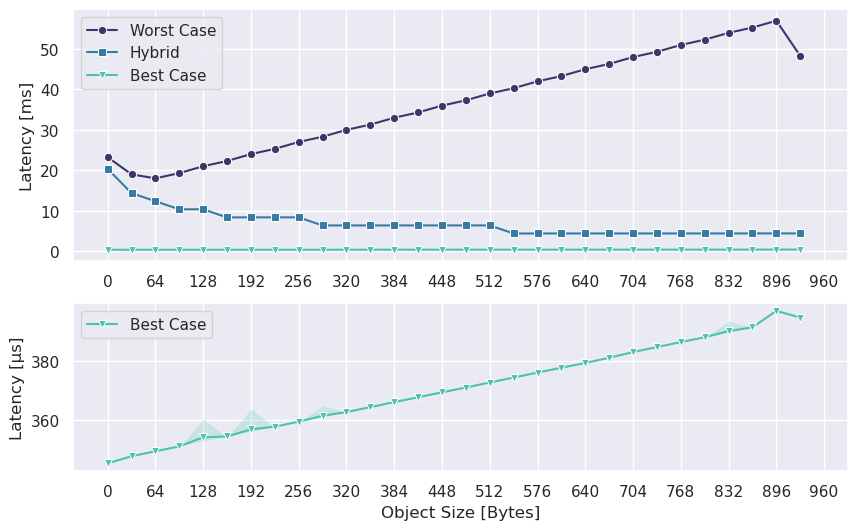

In [18]:
from util.plot import set_gird, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

set_theme()
fig = plt.figure(1)
fig.set_figheight(6)
fig.set_figwidth(10)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.5, 1]) 
ax = plt.subplot(gs[0])

unit = "ms"

if len(allocate_max) != 0:
    allocate_max_scaled = scale_data(allocate_max, unit)
    sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Hybrid", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_gird(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel(None)
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])


set_theme(3, 2)
ax = plt.subplot(gs[1])

unit = "µs"

# if len(allocate_max) != 0:
#     allocate_max_scaled = scale_data(allocate_max, unit)
#     sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
#     ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

#if len(allocate_case1) != 0:
#    allocate_case1_scaled = scale_data(allocate_case1, unit)
#    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Additional Example", markers=["o"], marker="s")
#    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_gird(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
# ax.set_ylim(bottom=340, top=2000)

save_plot("allocate")

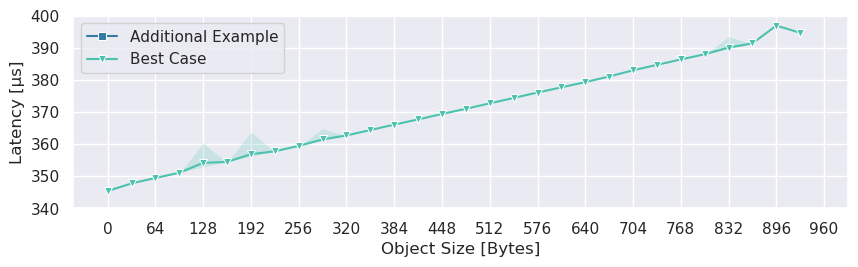

In [19]:
from util.plot import set_gird, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt

set_theme(3, 1)

fig, ax = plt.subplots()
fig.set_figheight(2.5)
fig.set_figwidth(10)

unit = "µs"

# if len(allocate_max) != 0:
#     allocate_max_scaled = scale_data(allocate_max, unit)
#     sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
#     ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Additional Example", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_gird(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
ax.set_ylim(bottom=340, top=400)


save_plot("allocate_min")
